# Sujet 1 : Concentration de CO2 dans l'atmosphère depuis 1958

## Traitement des données : pre-processing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import numpy as np

Extraction des données depuis l'url et création d'une copie locale :

In [2]:
data_url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'

In [3]:
# read data from url (and delete header)
raw_data = pd.read_csv(data_url, skiprows=44, names=['date','CO2'])
# path for local copy
file = '/home/jovyan/work/module3/exo3/weekly_in_situ_co2_mlo.csv'
# check existing local copy
try:
    local_data = pd.read_csv(file)
# if no local copy, create it
except FileNotFoundError:
    raw_data.to_csv('weekly_in_situ_co2_mlo.csv')
# read local copy
raw_data = pd.read_csv('weekly_in_situ_co2_mlo.csv')

Vérification et suppression de données manquantes :

In [4]:
raw_data[raw_data.isnull().any(axis=1)]
data = raw_data.dropna().copy()

Conversion des semaines :

In [5]:
import dateutil.parser
data['period'] = [dateutil.parser.parse(strdate) for strdate in data['date']]

Finalement, on obtient les émissions de CO2 en fonction du temps. On observe une superposition de deux effets : une évolution périodique et une évolution systématique.

            Unnamed: 0        date     CO2
period                                    
1958-03-29           0  1958-03-29  316.19
1958-04-05           1  1958-04-05  317.31
1958-04-12           2  1958-04-12  317.69
1958-04-19           3  1958-04-19  317.58
1958-04-26           4  1958-04-26  316.48
1958-05-03           5  1958-05-03  316.95
1958-05-17           6  1958-05-17  317.56
1958-05-24           7  1958-05-24  317.99
1958-07-05           8  1958-07-05  315.85
1958-07-12           9  1958-07-12  315.85


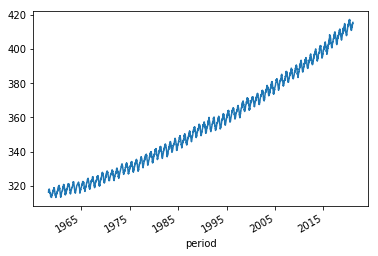

In [6]:
sorted_data = data.set_index('period').sort_index()
sorted_data['CO2'].plot()

## Détermination des modèles d'évolution
### Etude de l'évolution périodique
Calcul des émissions de CO2 pour l'année 1960 :

In [7]:
absc = []
ordo = []
for i in range(len(data.period)):
    if '1960' in data.date[i]:
        absc.append(data.period[i])
        ordo.append(data.CO2[i])
mean = np.mean(ordo)

L'oscillation périodique suit une évolution sinusoïdale :

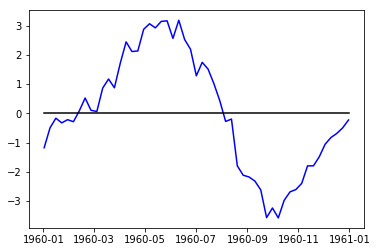

In [32]:
plt.plot(absc, ordo[:]-mean, color = 'b')
plt.plot(absc, [0]*len(absc), color = 'k')

### Etude de l'évolution systématique
L'évolution systématique peut être affichée en calculant une moyenne annuelle des émissions de CO2. Dans un premier temps, on calcule les émissions totales de CO2 par an :

In [9]:
yearly_incidence = [sorted_data['CO2'][0]]
year = ['1958']
ct = 0
week = [1]
for i in range(len(sorted_data)):
    yr = sorted_data['date'][i][:4]
    if yr != year[ct]:
        year.append(yr)
        yearly_incidence.append(sorted_data['CO2'][i])
        ct += 1
        week.append(1)
    else:
        yearly_incidence[ct] += sorted_data['CO2'][i]
        week[ct] += 1

Chaque année ne comptant pas le même nombre de semaines, on calcule la moyenne annuelle des émissions en divisant par le nombre de semaines :

In [10]:
yearly_incidence = [yearly_incidence[i]/week[i] for i in range(len(week))]

On peut ensuite tracer l'évolution des émissions de CO2 annuelles :

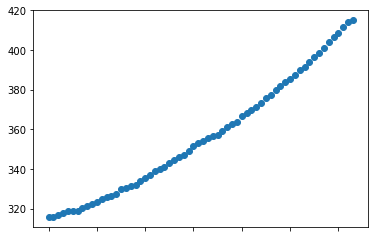

In [11]:
yearly_inc = pd.Series(data=yearly_incidence, index=year)
yearly_inc.plot(style='o')

On peut modéliser cette courbe par une interpolation polynomiale d'ordre 2 :

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
deg = 2
polyreg = make_pipeline(PolynomialFeatures(deg), LinearRegression())
polyreg.fit(np.array([int(i) for i in year]).reshape(-1, 1), yearly_incidence)
yearly_interp = pd.Series(polyreg.predict(np.array([int(i) for i in year]).reshape(-1, 1)), index = year)

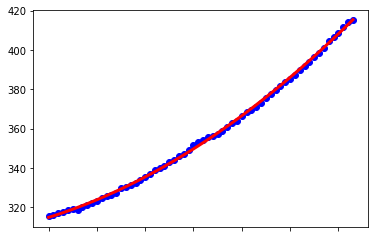

In [38]:
plt.figure()
yearly_inc.plot(style='bo')
yearly_interp.plot(linewidth=3, style='r')